# **NHL Game Prediction AI**

## **Section 1: Setup & Import** <a id="functions"></a>

In [1]:
# 🚀 Always run this cell first! It contains all necessary imports.

import gc
import sys
import pprint
import os

import requests
import json

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
from sklearn.tree import plot_tree
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve

import pickle
import joblib

## **Section 2: Functions** <a id="functions"></a>

In [2]:
# function get a list of functions defined in notebook
def printFunctions():
    functions_list = [name for name, obj in globals().items() if callable(obj) and obj.__module__ == '__main__']
    print("📌 Functions Defined in Notebook:")
    print("\n".join(functions_list))

In [3]:
#Function to load NHL Teams from API
def load_teamsFromAPI():
    
    # NHL API URL to get team list
    url = "https://api-web.nhle.com/v1/standings/now"  # API for current season standings (includes teams)
    response = requests.get(url)
    data = response.json()
    
    # Extract team codes
    teams = []
    
    for team in data["standings"]:
        teams.append({
            "teamAbbrev": team["teamAbbrev"],  # Short code (e.g., "PIT" for Pittsburgh Penguins)
            "teamName": team["teamName"],  # Full team name
        })
    
    # Convert to DataFrame
    df_teams = pd.DataFrame(teams)
    
    # Display first few rows
    df_teams.info()
    df_teams.head()

    return df_teams

In [4]:
#Function to load NHL players from API
def load_playersFromAPI(df_teams):
    
    all_players = []  # List to store all player data
    
    # Loop through each team and fetch their roster
    for index, team in df_teams.iterrows():
        team_name = team["teamName"]["default"]  # only extract the default value - it has a nested dictionary of format (default, value)
        team_abbrev = team["teamAbbrev"]["default"]
        
        print(f"Fetching roster for ({team_abbrev})...")
    
        # NHL API URL for team rosters
        roster_url = f"https://api-web.nhle.com/v1/roster/{team_abbrev}/20242025"
        
        try:
            response = requests.get(roster_url)
            data = response.json()
            
            # Loop through each category (Forwards, Goalies, Defense)
            for category, players in data.items():
                for player in players:
                    player_dict = player.copy()  # Copy player data
                    player_dict["position"] = category  # Add category (Forwards, Goalies, Defense)
                    player_dict["team"] = team_name  # Add team name
                    player_dict["teamAbbrev"] = team_abbrev  # Add team abbreviation
                    
                    all_players.append(player_dict)
    
        except Exception as e:
            print(f"Error fetching roster for {team_name}: {e}")
    
    # Convert to DataFrame
    df_players = pd.DataFrame(all_players)
    
    # Save to disk / CSV format
    df_players.to_csv("nhl_players_cleaned.csv", index=False)
    
    # Display first few rows
    df_players.info()
    df_players.head()

    return df_players

In [5]:
#Function load NHL games using the Scoreboard API
#includes games 21 days ago and 16 games into future

def load_gamesFromScoreboardAPI(APIRequestDate, df_teams):
    all_games = []  # List to store all games data
    
    # Loop through each team and fetch their games in the current season
    for index, team in df_teams.iterrows():
        team_name = team["teamName"]["default"]  # only extract the default value - it has a nested dictionary of format (default, value)
        team_abbrev = team["teamAbbrev"]["default"]
        
        print(f"Fetching games for ({team_abbrev})...")
        
        # NHL API URL for games this season for that team
        game_url = f"https://api-web.nhle.com/v1/scoreboard/{team_abbrev}/{APIRequestDate}"

        print(f"Fetching data from: {game_url}")
        
        try:
            #get API call - fetch game data
            response = requests.get(game_url)
            if response.status_code != 200:
                print(f"⚠️ Error: Received status code {response.status_code} from API")
                print(f"Response: {response.text}")  # Print error details
                continue  # Skip to next team if the request fails
            
            # retrieve JSON response
            data = response.json()

            # check if there's any data for this team
            if "gamesByDate" not in data or not data["gamesByDate"]:
                print(f"⚠️ No games found for {team_abbrev} on {APIRequestDate}")
                continue  # Skip to the next team
                
            # Loop through the JSON structure and pull out key game details (Game Date for that Team > Game > Key Fields) 
            for game_date in data["gamesByDate"]:
                            
                for game in game_date["games"]:
                    all_games.append({
                        "gameID": game["id"],
                        "gameDate": game["gameDate"],
                        "season": game["season"],
                        "gameDetailURL": game["gameCenterLink"],
                        "venue": game["venue"]["default"],
                        "startTime": game["startTimeUTC"],
                        "awayTeam": game["awayTeam"]["name"]["default"],
                        "awayTeamAbbrev": game["awayTeam"]["abbrev"],
                        "awayTeamScore": game.get("awayTeam",{}).get("score",0), # if score doesn't exist (game in future), then return 0 (for simplicity)
                        "homeTeam": game["homeTeam"]["name"]["default"],
                        "homeTeamAbbrev": game["homeTeam"]["abbrev"],
                        "homeTeamScore": game.get("homeTeam",{}).get("score",0) # if score doesn't exist (game in future), then return 0 (for simplicity)
                    })
            
        except Exception as e:
            print(f"Error fetching roster for {team_name}: {e}")  #error handling on API call
    
    
    # Convert to DataFrame
    df_games = pd.DataFrame(all_games)
    
    # Display first few rows
    df_games.info()
    df_games.head()   

    return df_games


In [6]:
# Function load NHL games from Club Schedule API
# the club-schedule-season API has all the data we need for a new df_games that has ALL games in the current season
def load_gamesFromClubScheduleAPI(df_teams):
    all_games = []  # List to store all games data
    
    # Loop through each team and fetch their games in the current season
    for index, team in df_teams.iterrows():
        team_name = team["teamName"]["default"]  # only extract the default value - it has a nested dictionary of format (default, value)
        team_abbrev = team["teamAbbrev"]["default"]
        
        print(f"Fetching games for ({team_abbrev})...")
        
        # NHL API URL for games this season for that team
        # now = current season = 20242025
        game_url = f"https://api-web.nhle.com/v1/club-schedule-season/{team_abbrev}/now"

        print(f"Fetching data from: {game_url}")
        
        try:
            #get API call - fetch game data
            response = requests.get(game_url)
            if response.status_code != 200:
                print(f"⚠️ Error: Received status code {response.status_code} from API")
                print(f"Response: {response.text}")  # Print error details
                continue  # Skip to next team if the request fails
            
            # retrieve JSON response
            data = response.json()

            # check if there's any data for this team
            if "games" not in data or not data["games"]:
                print(f"⚠️ No games found for {team_abbrev}")
                continue  # Skip to the next team

            # Loop through the JSON structure and pull out key game details (Game Date for that Team > Game > Key Fields) 
            for game in data["games"]:
                    
                    # Convert gameDate to a datetime object
                    game_date = datetime.datetime.strptime(game["gameDate"], "%Y-%m-%d").date()

                    # Only keep games that occurred today or earlier
                    if game_date < datetime.date.today():
                        all_games.append({
                            "gameID": game["id"],
                            "gameDate": game["gameDate"],
                            "season": game["season"],
                            "gameDetailURL": game["gameCenterLink"],
                            "venue": game["venue"]["default"],
                            "startTime": game["startTimeUTC"],
                            "awayTeam": game["awayTeam"]["commonName"]["default"],
                            "awayTeamAbbrev": game["awayTeam"]["abbrev"],
                            "awayTeamScore": game.get("awayTeam",{}).get("score",0), # if score doesn't exist (game in future), then return 0 (for simplicity)
                            "homeTeam": game["homeTeam"]["commonName"]["default"],
                            "homeTeamAbbrev": game["homeTeam"]["abbrev"],
                            "homeTeamScore": game.get("homeTeam",{}).get("score",0) # if score doesn't exist (game in future), then return 0 (for simplicity)
                        })
            
        except Exception as e:
            print(f"Error fetching roster for {team_name}: {e}")  #error handling on API call
    
    
    # Convert to DataFrame
    df_games = pd.DataFrame(all_games)
    
    # Display first few rows
    df_games.info()
    df_games.head()   

    return df_games

In [7]:
# Function to summarize player attributes per team (aka team features)
# the df_games_players merged data frame was too large because of N:M relationship between games and players
# we will pull aggregate stats from players and add them to the games data frame directly - so our data set is just for N games but added features
def summarizeTeamFeatures(df_players):
    
    #1 - Take mean of weight and height and add them to a temporary dataframe for aggregate player features by team
    df_team_features = df_players.groupby("teamAbbrev").agg({
        "weightInPounds": "mean",
        "heightInInches": "mean"
    }).reset_index()
    
    # Rename columns for clarity
    df_team_features.rename(columns={
        "weightInPounds": "avg_team_weight",
        "heightInInches": "avg_team_height"
    }, inplace=True)
    
    #2 lets convert birthdate to age and add to team features
    
    # Ensure birthDate is in datetime format
    df_players["birthDate"] = pd.to_datetime(df_players["birthDate"])
    
    # Function to calculate age
    def calculate_age(birthdate):
        today = pd.Timestamp.today()
        age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
        return age
    
    # Apply function to compute age
    df_players["age"] = df_players["birthDate"].apply(calculate_age)
    
    # Compute new feature: Average Age per Team  - **another temporary data frame, remember to delete
    df_team_age = df_players.groupby("teamAbbrev").agg({
        "age": "mean"
    }).reset_index().rename(columns={"age": "avg_team_age"})
    
    # Merge new feature into df_team_features without overwriting
    df_team_features = df_team_features.merge(df_team_age, on="teamAbbrev", how="left")

    #3a lets add nationality composition of each team by taking a count of players by birth country (the big ones)
    # Define function to categorize birth countries
    def categorize_birth_country(country):
        if country in ["CAN"]:
            return "CAN"
        elif country in ["USA"]:
            return "USA"
        elif country in ["SWE"]:
            return "SWE"
        elif country in ["FIN"]:
            return "FIN"
        elif country in ["RUS"]:
            return "RUS"
        else:
            return "OTHER"
    
    # Apply function to create a new column
    df_players["birthCountryCategory"] = df_players["birthCountry"].str.upper().apply(categorize_birth_country)
    
    # Display first few rows to verify
    df_players[["lastName", "birthCountry", "birthCountryCategory"]].head()

    # Aggregate birth country counts per team 
    # (1) group df_play by team and country, (2) size = count by grouping, (3) unstack = converts birthCountryCate values to columns, (4) reset index = turn team name from index to a column, create unique ID
    df_team_country_counts = df_players.groupby(["teamAbbrev", "birthCountryCategory"]).size().unstack(fill_value=0).reset_index()
    
    # Rename columns for clarity
    df_team_country_counts.rename(columns={
        "CAN": "num_CAN_players",
        "USA": "num_USA_players",
        "SWE": "num_SWE_players",
        "FIN": "num_FIN_players",
        "RUS": "num_RUS_players",
        "Other": "num_OTHER_players"
    }, inplace=True)
    
    # Merge new feature into df_team_features without overwriting
    df_team_features = df_team_features.merge(df_team_country_counts, on="teamAbbrev", how="left")

    # 4 Add feature for number of lefties and righties on team
    # Aggregate L and R shot counts per team 
    df_shot_counts = df_players.groupby(["teamAbbrev", "shootsCatches"]).size().unstack(fill_value=0).reset_index()
    
    # Rename columns for clarity
    df_shot_counts.rename(columns={
        "L": "num_LeftShot_players",
        "R": "num_RightShot_players",
    }, inplace=True)

    # Merge new feature into df_team_features without overwriting
    df_team_features = df_team_features.merge(df_shot_counts, on="teamAbbrev", how="left")
    
    return df_team_features

In [8]:
# Function to merge team features into games dataset    
#we'll have features for both the home and away teams, so we'll need to merge twice
def mergeTeamFeatures(df_team_features, df_games):
    #merge team player features with home team of games
    df_games = df_games.merge(df_team_features, left_on="homeTeamAbbrev", right_on="teamAbbrev", how="left")
    
    # Rename columns to indicate they are for the home team
    df_games.rename(columns={
        "avg_team_weight": "avg_home_weight",
        "avg_team_height": "avg_home_height",
        "avg_team_age": "avg_home_age",
        "num_CAN_players": "num_CAN_home",
        "num_FIN_players": "num_FIN_home",
        "OTHER": "num_OTHER_home",
        "num_RUS_players": "num_RUS_home",
        "num_SWE_players": "num_SWE_home",
        "num_USA_players": "num_USA_home",
        "num_LeftShot_players": "num_LeftShot_home",
        "num_RightShot_players": "num_RightShot_home"
    }, inplace=True)
    
    # Drop duplicate team column
    df_games.drop(columns=["teamAbbrev"], inplace=True)

    # do the same merge for the away team
    df_games = df_games.merge(df_team_features, left_on="awayTeamAbbrev", right_on="teamAbbrev", how="left")
    
    # Rename columns to indicate they are for the away team
    df_games.rename(columns={
        "avg_team_weight": "avg_away_weight",
        "avg_team_height": "avg_away_height",
        "avg_team_age": "avg_away_age",
        "num_CAN_players": "num_CAN_away",
        "num_FIN_players": "num_FIN_away",
        "OTHER": "num_OTHER_away",
        "num_RUS_players": "num_RUS_away",
        "num_SWE_players": "num_SWE_away",
        "num_USA_players": "num_USA_away",
        "num_LeftShot_players": "num_LeftShot_away",
        "num_RightShot_players": "num_RightShot_away"
    }, inplace=True)
    
    # Drop duplicate team column
    df_games.drop(columns=["teamAbbrev"], inplace=True)

    return df_games

In [9]:
# function to determine winning team and store in games dataset - will be used for training
def determineWinningTeam(df_games):
    # Determine winning team & add column 
    df_games["winningTeam"] = df_games.apply(
        lambda x: x["homeTeamAbbrev"] if x["homeTeamScore"] > x["awayTeamScore"] 
        else (x["awayTeamAbbrev"] if x["homeTeamScore"] < x["awayTeamScore"] else "Tie"),
        axis=1
    )

    # turn winning team into a 0 or 1 value for model training / prediction
    df_games["homeWin"] = (df_games["winningTeam"] == df_games["homeTeamAbbrev"]).astype(int)

    # Drop unneeded columns
    df_games = df_games.drop(columns=["winningTeam"])
    
    return df_games

In [10]:
#Function - calculation date range of games in dataset

def check_gameDateRangeInAPI(df):
    # Ensure gameDate is in datetime format
    df["gameDate"] = pd.to_datetime(df["gameDate"])
    
    # Compute min and max game dates
    min_game_date = df["gameDate"].min()
    max_game_date = df["gameDate"].max()
    
    print(f"📅 Earliest Game Date: {min_game_date}")
    print(f"📅 Latest Game Date: {max_game_date}")
    
    # Define the requested API date (replace "now" with actual date used in request)
    api_requested_date = datetime.datetime.today()  # If "now"
    # api_requested_date = datetime.datetime(2025, 2, 22)  # Example date used in request
    
    # Compute the difference between requested date and min/max game dates
    days_before = (api_requested_date - min_game_date).days
    days_after = (max_game_date - api_requested_date).days
    
    print(f"📉 Days Before Requested Date: {days_before} days")
    print(f"📈 Days After Requested Date: {days_after} days")

In [11]:
#Function to visualize number of teams by league
def plot_Teams(df_teams):
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df_teams["team_code"])
    plt.title("Number of Teams by Team Code")
    plt.xlabel("Team Code")
    plt.ylabel("Team Count")
    plt.show()

In [12]:
#Function to visualize player data - plot # of players by position
def plot_playerPosition(df_players):
    plt.figure(figsize=(8, 5))
    sns.countplot(y=df_players["position"], order=df_players["position"].value_counts().index, palette="coolwarm")    
    plt.title("Number of Players by Position", fontsize=14)
    plt.xlabel("Count")
    plt.ylabel("Position")
    plt.show()

In [13]:
# Function: visualize player height and weight distribution
def plot_playerSize(df_players):
    
    # Plot height distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(df_players["heightInInches"].dropna(), bins=20, kde=True, color="blue")
    plt.title("Distribution of Player Heights")
    plt.xlabel("Height (inches)")
    plt.ylabel("Count")
    plt.show()

    # weight distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(df_players["weightInPounds"].dropna(), bins=20, kde=True, color="red")
    plt.title("Distribution of Player Weights")
    plt.xlabel("Weight (lbs)")
    plt.ylabel("Count")
    plt.show()

    # height by position
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_players["position"], y=df_players["heightInInches"], palette="muted")
    plt.title("Player Height by Position")
    plt.xlabel("Position")
    plt.ylabel("Height (inches)")
    plt.show()

    # weight by position
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_players["position"], y=df_players["weightInPounds"], palette="muted")
    plt.title("Player Weight by Position")
    plt.xlabel("Position")
    plt.ylabel("Weight (lbs)")
    plt.show()

    # 10 heaviest players
    df_heaviest = df_players.sort_values(by="weightInPounds", ascending=False).head(10)

    #extract lastName from dictionary (key,value pairs for different languages in the dataset), and convest to string
    df_players["lastName"] = df_players["lastName"].apply(lambda x: x["default"] if isinstance(x, dict) else x)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(y=df_heaviest["lastName"], x=df_heaviest["weightInPounds"], palette="magma")
    plt.title("Top 10 Heaviest NHL Players")
    plt.xlabel("Weight (lbs)")
    plt.ylabel("Player Name")
    plt.show()
    

In [14]:
# function to plot home vs. away wins
def plotWinningTeam(df_games):
    
    # Count home and away wins
    home_wins = (df_games["winningTeam"] == df_games["homeTeamAbbrev"]).sum()
    away_wins = (df_games["winningTeam"] == df_games["awayTeamAbbrev"]).sum()
    ties = (df_games["winningTeam"] == "Tie").sum()
       
    # Data for visualization
    win_data = pd.DataFrame({
        "Category": ["Home Wins", "Away Wins", "Ties"],
        "Count": [home_wins, away_wins, ties]
    })
    
    # Create bar plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x="Category", y="Count", data=win_data, palette="coolwarm")
    plt.title("🏒 Home vs. Away Win Distribution")
    plt.ylabel("Number of Wins")
    plt.xlabel("Game Outcome")
    plt.show()

In [15]:
# Function to check dataset structure and print first 5 rows
def checkDataset(df):
    df.info()
    df.head()

In [16]:
#Function to print API response in a readable dictionary so we can investigate the structure
def read_APIResponseStructure(url):
    
    # Fetch game data
    response = requests.get(url)
    data = response.json()

    pp = pprint.PrettyPrinter(depth=4)  # Limits deep nesting
    pp.pprint(data)

In [17]:
# Monitor DataFrame Memory Usage

def show_memory_usage():
    """Displays memory usage of all DataFrames in global scope."""
    for var_name in list(globals()):
        var_value = globals()[var_name]
        if isinstance(var_value, (pd.DataFrame, pd.Series)):  # Check if it's a DataFrame
            print(f"{var_name}: {sys.getsizeof(var_value) / (1024 * 1024):.2f} MB")

show_memory_usage()  # Run this after loading data

In [18]:
# Delete Large DataFrames When No Longer Needed

def delete_dataframe(df):
    del df
    gc.collect()  # Force garbage collection


In [19]:
# Optimize DataFrame Column Types (from 64->32 float or int vars)

def optimize_dataframe(df):
    """Reduce memory usage by downcasting numerical columns."""
    for col in df.select_dtypes(include=['float64']):
        df[col] = df[col].astype('float32')
    for col in df.select_dtypes(include=['int64']):
        df[col] = df[col].astype('int32')
    return df


In [20]:
# remove hidden variables that are taking up memory

def remove_hidden_variables():
    %reset out -f


## **Section 3: Load & Save Data** <a id="data_load"></a>

In [21]:
# Load NHL Teams
# NB --> improvements: (1) add a file_age condition, (2) add a boolean y/n refresh, (3) turn this into general function for any dataset

# 📂 File path for the saved dataset
file_path_teams = "df_teams_cleaned.csv"

#load NHL teams data from API if file doesn't exist / not saved already
if os.path.exists(file_path_teams):
    print("📂 Teams CSV file found! Loading from saved file...")
    df_teams = pd.read_csv(file_path_teams)
else:
    print("🌍 Teams CSV file not found. Fetching data from API...")
    df_teams = load_teamsFromAPI()  
    df_teams.to_csv(file_path_teams, index=False)  # Save for future use

#verify
checkDataset(df_teams)

📂 Teams CSV file found! Loading from saved file...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   teamAbbrev  32 non-null     object
 1   teamName    32 non-null     object
dtypes: object(2)
memory usage: 644.0+ bytes


In [22]:
# Load NHL Players

# 📂 File path for the saved dataset
file_path_players = "df_players_cleaned.csv"

#load NHL players data from API if file doesn't exist / not saved already
if os.path.exists(file_path_players):
    print("📂 Players CSV file found! Loading from saved file...")
    df_players = pd.read_csv(file_path_players)
else:
    print("🌍 Players CSV file not found. Fetching data from API...")
    df_players = load_playersFromAPI(df_teams)  
    df_players.to_csv(file_path_players, index=False)  # Save for future use

#verify
checkDataset(df_players)

📂 Players CSV file found! Loading from saved file...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   769 non-null    int64 
 1   headshot             769 non-null    object
 2   firstName            769 non-null    object
 3   lastName             769 non-null    object
 4   sweaterNumber        769 non-null    int64 
 5   positionCode         769 non-null    object
 6   shootsCatches        769 non-null    object
 7   heightInInches       769 non-null    int64 
 8   weightInPounds       769 non-null    int64 
 9   heightInCentimeters  769 non-null    int64 
 10  weightInKilograms    769 non-null    int64 
 11  birthDate            769 non-null    object
 12  birthCity            769 non-null    object
 13  birthCountry         769 non-null    object
 14  birthStateProvince   534 non-null    object
 15  posi

In [23]:
# Load NHL Games

# 📂 File path for the saved dataset
file_path_games = "df_games_cleaned.csv"

#load NHL games data from API if file doesn't exist / not saved already
if os.path.exists(file_path_games):
    print("📂 Games CSV file found! Loading from saved file...")
    df_games = pd.read_csv(file_path_games)
else:
    print("🌍 Games CSV file not found. Fetching data from API...")
    df_games = load_gamesFromClubScheduleAPI(df_teams)  
    df_games.to_csv(file_path_games, index=False)  # Save for future use

#verify
checkDataset(df_games)

📂 Games CSV file found! Loading from saved file...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067 entries, 0 to 2066
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gameID          2067 non-null   int64 
 1   gameDate        2067 non-null   object
 2   season          2067 non-null   int64 
 3   gameDetailURL   2067 non-null   object
 4   venue           2067 non-null   object
 5   startTime       2067 non-null   object
 6   awayTeam        2067 non-null   object
 7   awayTeamAbbrev  2067 non-null   object
 8   awayTeamScore   2067 non-null   int64 
 9   homeTeam        2067 non-null   object
 10  homeTeamAbbrev  2067 non-null   object
 11  homeTeamScore   2067 non-null   int64 
dtypes: int64(4), object(8)
memory usage: 193.9+ KB


In [24]:
printFunctions()

📌 Functions Defined in Notebook:
printFunctions
load_teamsFromAPI
load_playersFromAPI
load_gamesFromScoreboardAPI
load_gamesFromClubScheduleAPI
summarizeTeamFeatures
mergeTeamFeatures
determineWinningTeam
check_gameDateRangeInAPI
plot_Teams
plot_playerPosition
plot_playerSize
plotWinningTeam
checkDataset
read_APIResponseStructure
show_memory_usage
delete_dataframe
optimize_dataframe
remove_hidden_variables


## **Section 4: Data Preprocessing & Feature Engineering** <a id="data_processing"></a>

In [25]:
# Create a copy of games dataset for use in modeling
df_model = df_games

In [26]:
# Summarize player features/attributes by team - eg avg weight, height, age, nationality, L/R shot
df_team_features = summarizeTeamFeatures(df_players)

#Merge summary team features into the games dataset
df_model = mergeTeamFeatures(df_team_features, df_model)

checkDataset(df_team_features)
checkDataset(df_model)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   teamAbbrev             32 non-null     object 
 1   avg_team_weight        32 non-null     float64
 2   avg_team_height        32 non-null     float64
 3   avg_team_age           32 non-null     float64
 4   num_CAN_players        32 non-null     int64  
 5   num_FIN_players        32 non-null     int64  
 6   OTHER                  32 non-null     int64  
 7   num_RUS_players        32 non-null     int64  
 8   num_SWE_players        32 non-null     int64  
 9   num_USA_players        32 non-null     int64  
 10  num_LeftShot_players   32 non-null     int64  
 11  num_RightShot_players  32 non-null     int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 3.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067 entries, 0 to 2066
Data columns (total 34 columns):


In [27]:
#Add the target (Y variable) to the model (winning team: 0 or 1 if home team wins)
df_model = determineWinningTeam(df_model)

y = df_model["homeWin"]

checkDataset(y)

<class 'pandas.core.series.Series'>
RangeIndex: 2067 entries, 0 to 2066
Series name: homeWin
Non-Null Count  Dtype
--------------  -----
2067 non-null   int64
dtypes: int64(1)
memory usage: 16.3 KB


In [28]:
#Define the features (X variable) of the model

# Select features for the model (from the 
features = [
    "avg_home_weight", "avg_away_weight",
    "avg_home_height", "avg_away_height",
    "homeTeamScore", "awayTeamScore",
    "avg_home_age", "avg_away_age",
    "num_LeftShot_home", "num_RightShot_home",
    "num_LeftShot_away", "num_RightShot_away",
    "num_CAN_home", "num_CAN_away",
    "num_USA_home", "num_USA_away",
    "num_FIN_home", "num_FIN_away",
    "num_SWE_home", "num_SWE_away",
    "num_RUS_home", "num_RUS_away",
    "num_OTHER_home", "num_OTHER_away"
]

X = df_model[features]

checkDataset(X)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067 entries, 0 to 2066
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   avg_home_weight     2066 non-null   float64
 1   avg_away_weight     2067 non-null   float64
 2   avg_home_height     2066 non-null   float64
 3   avg_away_height     2067 non-null   float64
 4   homeTeamScore       2067 non-null   int64  
 5   awayTeamScore       2067 non-null   int64  
 6   avg_home_age        2066 non-null   float64
 7   avg_away_age        2067 non-null   float64
 8   num_LeftShot_home   2066 non-null   float64
 9   num_RightShot_home  2066 non-null   float64
 10  num_LeftShot_away   2067 non-null   int64  
 11  num_RightShot_away  2067 non-null   int64  
 12  num_CAN_home        2066 non-null   float64
 13  num_CAN_away        2067 non-null   int64  
 14  num_USA_home        2066 non-null   float64
 15  num_USA_away        2067 non-null   int64  
 16  num_FI

In [29]:
#Fill missing values with mean

X.fillna(X.mean(), inplace=True)

/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_9455/3252690266.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


In [30]:
#Scale features that have different ranges - so that they have mean ~ 0 and std dev ~ 1, ideal for model performance

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardizes all numeric features

In [31]:
#Split data between training set (80% of X) and validation/testing set (20% of X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# random_state provides a seed so that results are re-producable (same sample each time)
# stratify preserves the distribution of y / homeWin in each sample (eg. 60% home wins)

In [32]:
show_memory_usage()

df_teams: 0.01 MB
df_players: 0.62 MB
df_games: 1.06 MB
df_model: 1.42 MB
df_team_features: 0.00 MB
y: 0.02 MB
X: 0.38 MB
y_train: 0.03 MB
y_test: 0.01 MB


## **Section 5: Model 1 - Logistic Regression** <a id="logistic_model"></a>

### **Section 5a: Train a Model (Logistic Regression)** <a id="logistic_train"></a> ###

In [33]:
# 🚀 Initialize the model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# 🚀 Train the model
log_reg.fit(X_train, y_train)

# 🚀 Make predictions
y_pred = log_reg.predict(X_test)


### **Section 5b: Evaluate a Model (Logistic Regression)** <a id="logistic_eval"></a> ###

In [34]:
# 🚀 Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy:.2%}")

# 🚀 Confusion Matrix
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 🚀 Detailed Classification Report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

"""
Accuracy: Percentage of correct predictions
Confusion Matrix: Shows how many games were classified correctly/incorrectly
Precision & Recall: Helps balance false positives vs. false negatives
F1-score: Combines precision & recall into a single score 
"""

✅ Model Accuracy: 100.00%
📊 Confusion Matrix:
[[187   0]
 [  0 227]]
📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       187
           1       1.00      1.00      1.00       227

    accuracy                           1.00       414
   macro avg       1.00      1.00      1.00       414
weighted avg       1.00      1.00      1.00       414



'\nAccuracy: Percentage of correct predictions\nConfusion Matrix: Shows how many games were classified correctly/incorrectly\nPrecision & Recall: Helps balance false positives vs. false negatives\nF1-score: Combines precision & recall into a single score \n'

Intercept (Bias Term): 0.9278


/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_9455/565570292.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feature_weights["Feature"], x=feature_weights["Beta Weight"], palette="coolwarm")


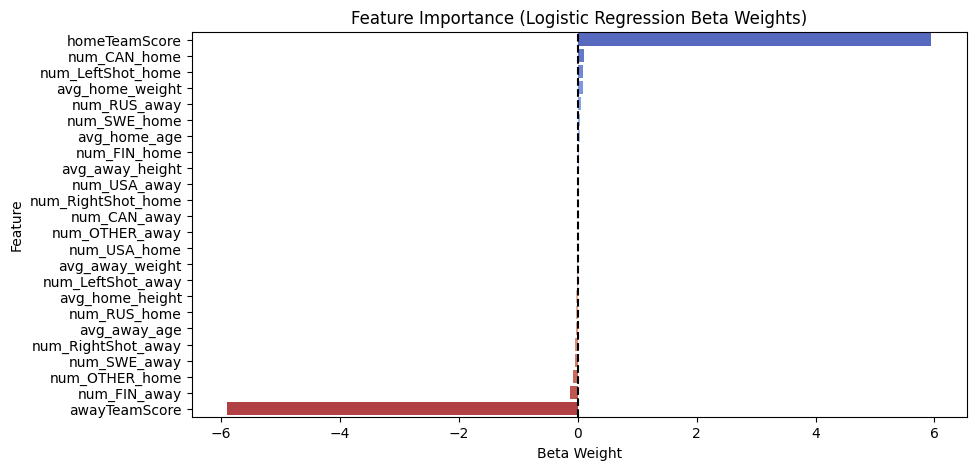

In [35]:
# review the weights (beta) of each feature post-training to see which has greatest impact

# 🚀 Get beta (β) coefficients for each feature
beta_weights = log_reg.coef_[0]  # log_reg is the trained Logistic Regression model

# 🚀 Get intercept (bias term)
intercept = log_reg.intercept_[0]

# 🚀 Create DataFrame for easy viewing
feature_weights = pd.DataFrame({"Feature": X.columns, "Beta Weight": beta_weights})
feature_weights = feature_weights.sort_values(by="Beta Weight", ascending=False)  # Sort by impact

# 🚀 Display results
print(f"Intercept (Bias Term): {intercept:.4f}")
feature_weights

# plot the weights 
plt.figure(figsize=(10, 5))
sns.barplot(y=feature_weights["Feature"], x=feature_weights["Beta Weight"], palette="coolwarm")
plt.axvline(0, color="black", linestyle="--")  # Add reference line at 0
plt.title("Feature Importance (Logistic Regression Beta Weights)")
plt.xlabel("Beta Weight")
plt.ylabel("Feature")
plt.show()

### **Section 5c: Fine-Tune the Model (Logistic Regression)** ### <a id="logistic_finetune"></id>

*100% accuracy in Logistic Regression is usually a sign of overfitting, and the reason is your model is using the homeTeamScore and awayTeamScore to "cheat" and directly determine the winner (since the game score already tells us who won).*

**🔍 Why Is This Happening?**
- The model is "learning" from the final score, which directly decides whether a home win (homeWin = 1) happened.
- The beta weights for homeTeamScore (+5) and awayTeamScore (-5) are extreme, compared to all other features (≤0.1).
- This means the model is not actually learning a predictive pattern from team stats—it’s just memorizing outcomes.

** How to Fix?**
Since we want to predict the game outcome before it happens, the final scores shouldn’t be included in training.

In [36]:
 # 🚀 Remove target-leaking features (game scores)
X_filtered = X.drop(columns=["homeTeamScore", "awayTeamScore"])

# 🚀 Scale features again
scaler = StandardScaler()
X_scaled_filtered = scaler.fit_transform(X_filtered)

# 🚀 Split dataset again
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_filtered, y, test_size=0.2, random_state=42, stratify=y
)

# 🚀 Train Logistic Regression again
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# 🚀 Make new predictions
y_pred = log_reg.predict(X_test)

# 🚀 Evaluate model again
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ New Model Accuracy (without team scores): {accuracy:.2%}")

# 🚀 Re-check feature weights
beta_weights_filtered = log_reg.coef_[0]
feature_weights_filtered = pd.DataFrame({"Feature": X_filtered.columns, "Beta Weight": beta_weights_filtered})
feature_weights_filtered = feature_weights_filtered.sort_values(by="Beta Weight", ascending=False)
feature_weights_filtered

✅ New Model Accuracy (without team scores): 56.28%


,Feature,Beta Weight
4,avg_home_age,0.182004
2,avg_home_height,0.172268
14,num_FIN_home,0.131792
18,num_RUS_home,0.108899
11,num_CAN_away,0.090705
13,num_USA_away,0.089764
6,num_LeftShot_home,0.083640
20,num_OTHER_home,0.059022
7,num_RightShot_home,0.050804
0,avg_home_weight,0.049818


**Top 3 Factors That Increase Home Wins**
| Feature	| Beta Weight (β) |	Interpretation|
|-----------|-----------------|-----------|
|avg_home_age | +0.1817 |	Older home teams tend to win more.|
|avg_home_height	| +0.1720 |	Taller home teams have a slight advantage.|
|num_FIN_home | +0.1316 |	More Finnish players on the home team correlate with higher win probability.|

**🏆 Key Takeaway: Home teams with experienced (older), taller players, and strong Finnish presence tend to perform better!**

**56% accuracy is (just) above random chance.  How do we improve?**

1. Try a More Complex Model → Random Forest or XGBoost can find nonlinear patterns that Logistic Regression misses.
2. Feature Engineering → Add more game context:
    1. Home Win Streak – Is the home team on a winning streak?
    2. Away Travel Fatigue – Did the away team play a back-to-back game?
    3. Goalie Performance – Consider starting goalies' stats.
3. Hyperparameter Tuning → Adjust Logistic Regression settings (C, solver, penalty) to improve performance.

We will try #3 since we don't have more data/context for #2 right now.  Then we'll move on to a more complex model.

### **Section 5d: Hyperparameter tuning** <a id="logistics_hyper"></a>

Logistic Regression has several key hyperparameters that affect performance:

| Hyperparameter |	Effect |
|----------------|---------|
|C  |	Regularization strength (higher values reduce regularization, lower values prevent overfitting) |
|solver |	Optimization algorithm (e.g., liblinear, lbfgs, saga) |
|penalty |	Type of regularization (l1, l2, elasticnet, none) |
|max_iter |	Number of iterations for convergence (increase if model doesn't converge) |


In [37]:
# We'll search for the best combination of hyperparameters using GridSearchCV, which tests multiple values and selects the best model.

# 🚀 Define the hyperparameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],  # Regularization strength
    "solver": ["liblinear", "lbfgs", "saga"],  # Different optimization algorithms
    "penalty": ["l1", "l2"],  # Regularization types
    "max_iter": [500, 1000, 2000]  # Ensure convergence
}

# 🚀 Initialize Logistic Regression model
log_reg = LogisticRegression(random_state=42)

# 🚀 Set up GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring="accuracy", n_jobs=-1)

# 🚀 Train the model with different hyperparameters
grid_search.fit(X_train, y_train)

# 🚀 Get the best model and hyperparameters
best_log_reg = grid_search.best_estimator_
best_params = grid_search.best_params_
print("✅ Best Hyperparameters:", best_params)

# 🚀 Evaluate the tuned model
y_pred_tuned = best_log_reg.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)

print(f"✅ Tuned Model Accuracy: {accuracy_tuned:.2%}")


/Users/liammckendry/hockey_ai/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/liammckendry/hockey_ai/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Best Hyperparameters: {'C': 0.1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
✅ Tuned Model Accuracy: 56.52%


/Users/liammckendry/hockey_ai/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/liammckendry/hockey_ai/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
75 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/liammckendry/hockey_ai/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/liammckendry/hocke

**What Each Hyperparameter Means**
|Hyperparameter |	Value Found |	What It Does|
|---|---|---|
|C|	0.1|	Regularization strength: Lowers overfitting by penalizing large weights. A smaller C means stronger regularization.|
|max_iter|	500|	Number of iterations: Ensures the model has enough time to converge.|
|penalty	|'l2'	|L2 Regularization (Ridge): Shrinks feature weights but doesn’t remove them entirely. Helps with generalization.|
|solver	|'lbfgs'	|Optimization algorithm: lbfgs is a robust solver for small to medium datasets. Works well with L2 regularization.|

**Your original Logistic Regression accuracy was ~57%, and now it’s 56.52%, meaning the tuning didn’t drastically change performance.**

**Here’s why:**
1. The Model is Limited: Logistic Regression is a linear model, meaning it can’t capture complex patterns or interactions between player/team stats and game outcomes.
2. Regularization Didn’t Help Much: The model selected C = 0.1 (stronger regularization), which suggests reducing complexity slightly helped, but not enough to significantly improve performance.
3. Feature Selection Still Matters: If important predictive features are missing, hyperparameter tuning can’t fix that.
4. A More Complex Model Might Be Needed: Logistic Regression is great for interpretation, but Random Forest or XGBoost can capture nonlinear relationships better.

## **Section 6: Model 2 - Random Forest Model** <a id="rf_model"></a> ##

**What is Random Forest?**
- Ensemble learning method that combines multiple decision trees
- Each tree votes on the outcome, reducing overfitting
- Works well for structured data, like NHL player/team stats

**Why is it better than Logistic Regression?**
|Feature|	Logistic Regression|	Random Forest|
|---|---|---|
|Captures Complex Interactions	|❌ No|	✅ Yes|
|Non-Linear Relationships|	❌ No|	✅ Yes|
|Handles Missing Data|	❌ No	|✅ Yes|
|Feature Importance Analysis|	❌ Harder|	✅ Built-in|

### **Section 6a: Train a Model (Random Forest)** <a id="rf_train"></a> ###

In [38]:
# 🚀 Initialize Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 🚀 Train the Model
rf_model.fit(X_train, y_train)

# 🚀 Make Predictions
y_pred_rf = rf_model.predict(X_test)


### **Section 6b: Evaluate a Model (Random Forest)** <a id="rf_eval"></a> ###

In [39]:
# 🚀 Evaluate Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"✅ Random Forest Model Accuracy: {accuracy_rf:.2%}")

# 🚀 Display Confusion Matrix
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# 🚀 Classification Report (Precision, Recall, F1-Score)
print("📊 Classification Report:")
print(classification_report(y_test, y_pred_rf))

✅ Random Forest Model Accuracy: 80.92%
📊 Confusion Matrix:
[[146  41]
 [ 38 189]]
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       187
           1       0.82      0.83      0.83       227

    accuracy                           0.81       414
   macro avg       0.81      0.81      0.81       414
weighted avg       0.81      0.81      0.81       414



**The confusion matrix shows how many predictions were correct vs. incorrect for both classes:**

|Actual \ Predicted	Predicted |Home Loss (0)|	Predicted Home Win (1)|	Total|
|--|--|--|--|
|Actual Home Loss (0)|	✅ 146 (Correctly Predicted Losses)|	❌ 41 (Incorrectly Predicted Wins)|	187|
|Actual Home Win (1)|	❌ 38 (Incorrectly Predicted Losses)|	✅ 189 (Correctly Predicted Wins)	|227|

**The Classification Report tells us how well the model performs per category (home loss vs. home win).**

|Metric|	Home Loss (0)|	Home Win (1)|	What It Means|
|--|--|--|--|
|Precision|	0.79|	0.82|	Out of all predicted losses/wins, how many were correct?|
|Recall	|0.78	|0.83	|Out of all actual losses/wins, how many did we correctly predict?|
|F1-score|	0.79|	0.83|	Harmonic mean of precision & recall (higher = better balance).|
|Support|	187	|227|	Total number of cases per category.|

/var/folders/mj/ndpf249j5rn7jzxyb81srz4w0000gn/T/ipykernel_9455/1000542236.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feature_importance["Feature"], x=feature_importance["Importance"], palette="coolwarm")


               Feature  Importance
5         avg_away_age    0.068337
4         avg_home_age    0.062559
1      avg_away_weight    0.062377
0      avg_home_weight    0.062169
3      avg_away_height    0.059947
2      avg_home_height    0.058858
9   num_RightShot_away    0.048140
11        num_CAN_away    0.046936
12        num_USA_home    0.045943
10        num_CAN_home    0.045704
7   num_RightShot_home    0.043268
13        num_USA_away    0.043035
8    num_LeftShot_away    0.041888
6    num_LeftShot_home    0.041451
16        num_SWE_home    0.036684
20      num_OTHER_home    0.034711
18        num_RUS_home    0.034585
17        num_SWE_away    0.034014
21      num_OTHER_away    0.033602
19        num_RUS_away    0.033145
15        num_FIN_away    0.032923
14        num_FIN_home    0.029722


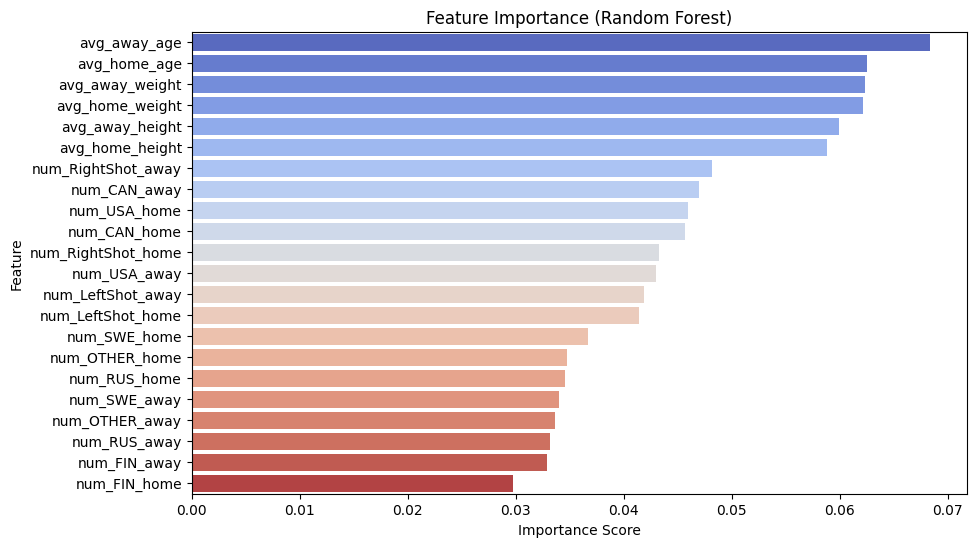

In [40]:
# 🚀 Get feature importance
feature_importance = pd.DataFrame({
    "Feature": X_filtered.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

#print feature importance in table
print(feature_importance)

# 🚀 Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(y=feature_importance["Feature"], x=feature_importance["Importance"], palette="coolwarm")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

**Visualizing Decision Trees in Random Forest Model**
Since Random Forest is an ensemble of many decision trees, we can extract and visualize individual trees to understand how the model makes decisions.

**Process**
1. Since Random Forest has multiple trees, we can pick one tree and visualize its structure.
2. To visualize a tree graphically, use plot_tree(). Darker colos = stronger decisions.  Splits are based on most important features
3. Since Random Forest trees are deep, we can limit the depth for easier interpretation.

**NB: This is only 1 tree!**
*Random forest produces collection of decision trees.  Each tree is based on a subset of the training data and a subset of features (X columns).  Decision trees are aggregated by - for each hockey game record (Xi), it runs it through each tree to predict win/loss; then either takes majority vote (for classification problems like this won - win/loss) or average (for continuous values)*

In [41]:
# 🚀 Extract one of the trees (e.g., the first tree in the forest)
single_tree = rf_model.estimators_[0]

# 🚀 Display the decision rules of the tree
tree_rules = export_text(single_tree, feature_names=list(X_filtered.columns))
print(tree_rules)


|--- avg_away_age <= -0.13
|   |--- num_SWE_home <= 0.71
|   |   |--- avg_away_height <= 1.70
|   |   |   |--- num_LeftShot_away <= -1.33
|   |   |   |   |--- avg_home_weight <= 1.91
|   |   |   |   |   |--- avg_home_age <= -0.44
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- avg_home_age >  -0.44
|   |   |   |   |   |   |--- num_USA_home <= -1.58
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- num_USA_home >  -1.58
|   |   |   |   |   |   |   |--- avg_home_weight <= -0.91
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- avg_home_weight >  -0.91
|   |   |   |   |   |   |   |   |--- num_SWE_home <= -0.54
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |--- num_SWE_home >  -0.54
|   |   |   |   |   |   |   |   |   |--- avg_away_height <= -0.45
|   |   |   |   |   |   |   |   |   |   |--- num_SWE_home <= 0.08
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of de

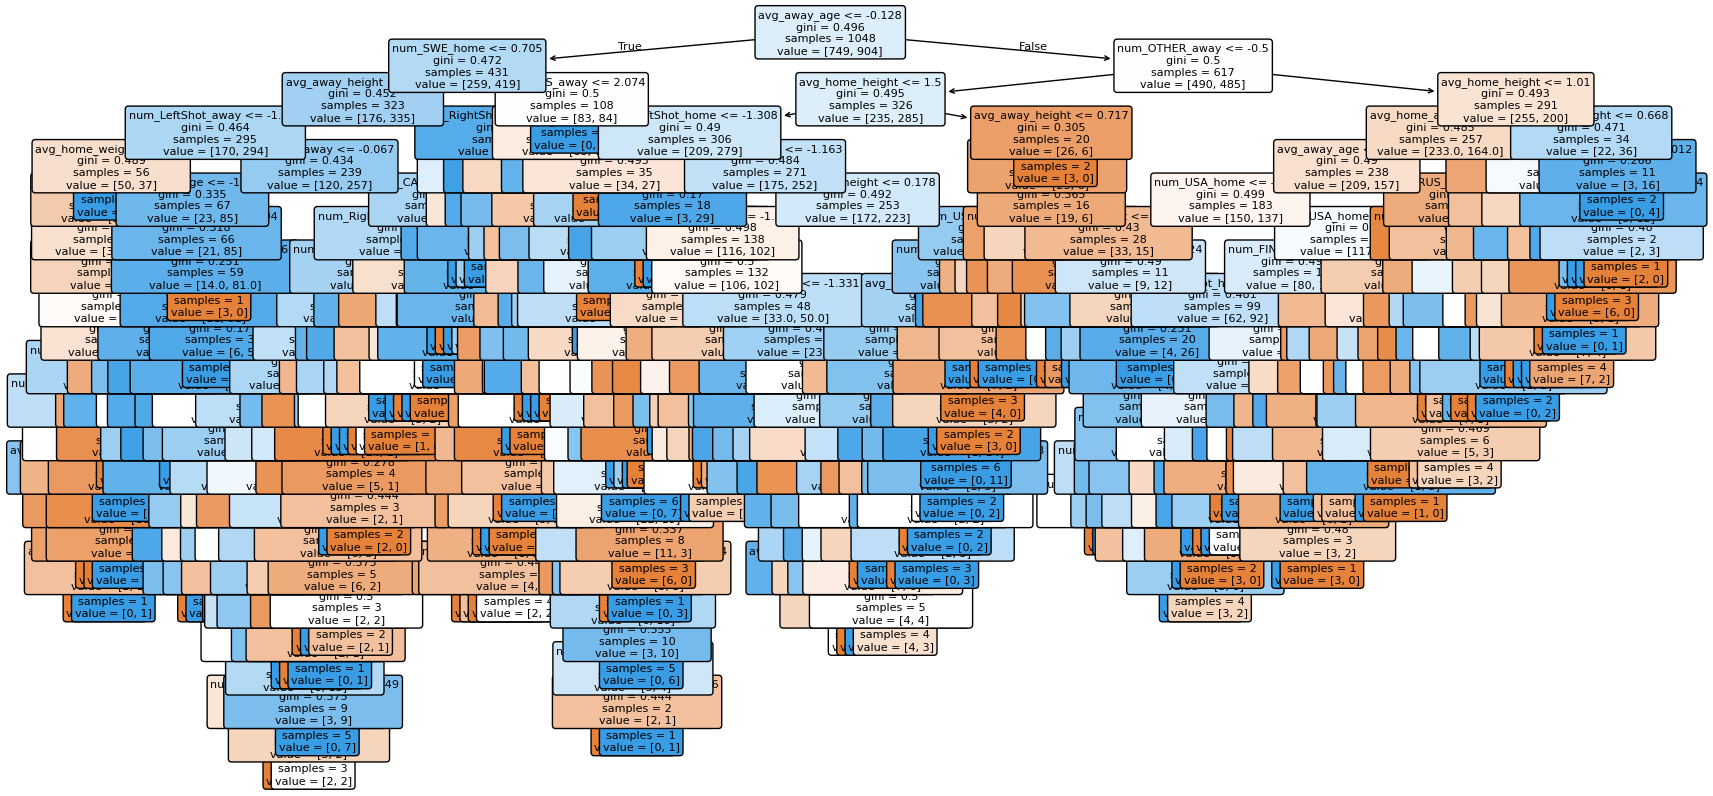

In [42]:
# 🚀 Set figure size
plt.figure(figsize=(20,10))

# 🚀 Plot a single tree
plot_tree(single_tree, feature_names=X_filtered.columns, filled=True, rounded=True, fontsize=8)

# 🚀 Show plot
plt.show()


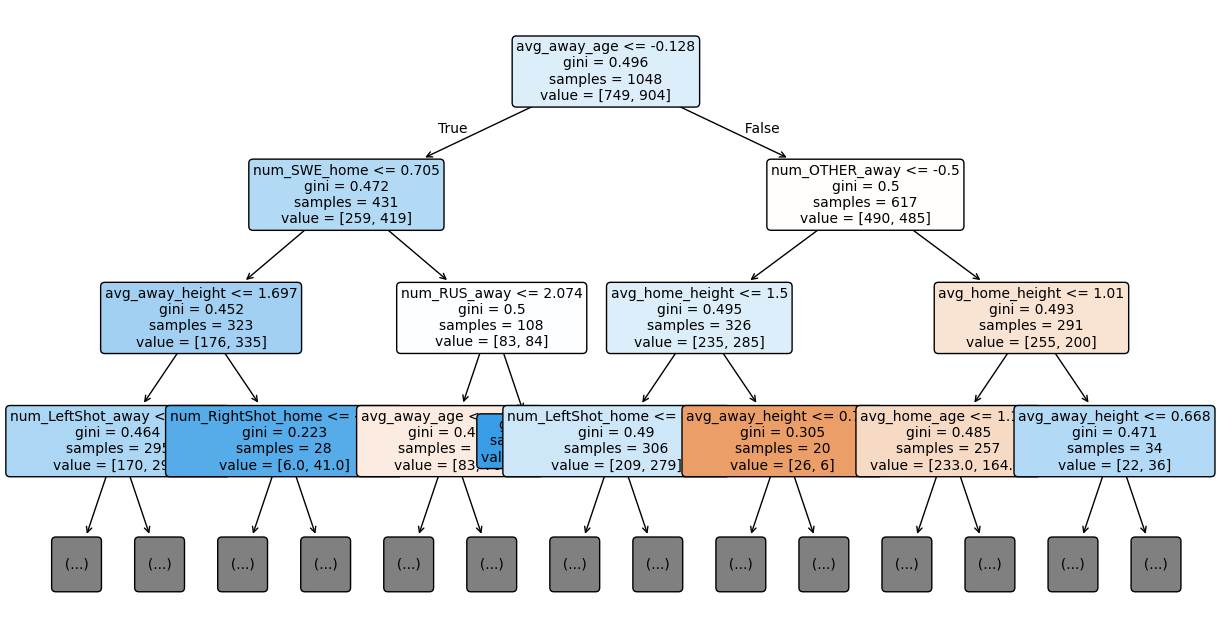

In [43]:
#print again limiting tree depth to 3 layers for readability
plt.figure(figsize=(15, 8))
plot_tree(single_tree, feature_names=X_filtered.columns, max_depth=3, filled=True, rounded=True, fontsize=10)
plt.show()

**Understanding the Elements in a Decision Tree Node**

Each box (node) in the tree contains important information:

|Term|	Meaning|	What It Tells Us|
|--|--|--|
|Feature (e.g., avg_home_age ≤ 27.5)|	The decision rule used to split the data at this point.	|The condition that determines whether the decision moves left (True) or right (False).|
|Gini (Impurity Score)|	Measures how pure the node is. Lower is better (0 = perfect split).	|If Gini = 0.0, all samples in that node belong to one class (pure).|
|Samples|	Number of data points at this node.	|If samples=200, it means this split applies to 200 games.|
|Value	[X, Y] = Number of samples in each class (e.g., [90, 110]).	|Shows how many home wins (1) vs. home losses (0) are at this node.|
|Class (Majority Class)	The predicted outcome based on majority class.	|If homeWin = 1 has more samples, the model predicts home win at this node.|

### **Section 6c: Hyperparameter tuning** <a id="rf_hyper"></a>

**Key Hyperparameters to Tune**

Random Forest has several important hyperparameters that affect model accuracy and efficiency.

|Hyperparameter|	What It Does|	Effect on Model|
|--|--|--|
|n_estimators|	Number of decision trees in the forest	|More trees = better performance, but slower training|
|max_depth	|Maximum depth of each tree	|Limits tree growth to reduce overfitting|
|min_samples_split|	Minimum samples needed to split a node	|Higher = more generalization, Lower = more overfitting|
|min_samples_leaf	|Minimum samples per leaf node	|Prevents small, unreliable splits|
|max_features	|Number of features used per tree	|Lower = more randomness, Higher = more accuracy|

We’ll use GridSearchCV to test multiple values and find the best combination.

In [44]:
# 🚀 Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of trees
    "max_depth": [10, 20, None],  # Limit tree depth
    "min_samples_split": [2, 5, 10],  # Minimum samples per split
    "min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf
    "max_features": ["sqrt", "log2"]  # Number of features per tree
}

# 🚀 Initialize Random Forest
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# 🚀 Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)

# 🚀 Train with hyperparameter tuning
grid_search.fit(X_train, y_train)

# 🚀 Best hyperparameters & accuracy
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_
print("✅ Best Hyperparameters:", best_params)

# 🚀 Evaluate Tuned Model
y_pred_rf_tuned = best_rf_model.predict(X_test)
accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)

print(f"✅ Tuned Random Forest Accuracy: {accuracy_rf_tuned:.2%}")


Fitting 5 folds for each of 162 candidates, totalling 810 fits
✅ Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
✅ Tuned Random Forest Accuracy: 81.40%


**Interperting Best Hyperparameter Results**

|Hyperparameter|	Chosen Value|	What This Means|
|--|--|--|
|max_depth=None	|No limit on tree depth	| Trees grow fully unless stopped by other criteria.
|max_features='sqrt' |	Randomly selects √(num features) per tree	| Encourages diversity between trees (less overfitting).
|min_samples_leaf=1	|A leaf node can have just 1 sample	| Maximizes depth but may lead to overfitting.
|min_samples_split=2 |	A node splits if it has 2 or more samples |	Allows deep trees but could lead to very specific splits.
|n_estimators=50	| Uses 50 decision trees in the forest	| A smaller forest speeds up training but could be less stable.

**Should We Tune Further?**

*Pros of This Model*
- Accuracy slightly improved (81.40%) – The model is performing well.
- Uses feature randomness (sqrt) – Helps prevent overfitting.
- Fully grown trees (max_depth=None) – Allows trees to learn complex patterns.

*Possible Issues*
- Overfitting risk? min_samples_leaf=1 and max_depth=None means the trees grow very deep, capturing every small detail in the training data.
- Too few trees (n_estimators=50)? Increasing trees might improve stability at the cost of computation time.

## **Section 7: Model 3 - XGBoost** <a id="xgb_model"></a> ##

**What is XGBoost?**

XGBoost (eXtreme Gradient Boosting) is an advanced tree-based algorithm that: 
- Uses Gradient Boosting, meaning it builds trees sequentially, where each tree corrects mistakes from the previous one.
- Performs better than Random Forest in many cases because it learns from past errors instead of growing independent trees.
- Has built-in regularization to prevent overfitting.

**Used for classification problems like home/win prediction**

### **Section 7a: Train a Model (XGBoost)** <a id="xgb_train"></a> ###

In [45]:
# 🚀 Initialize the XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,  # Number of trees
    max_depth=6,  # Limits tree depth to prevent overfitting
    learning_rate=0.1,  # Controls step size (0.1 is a common starting point)
    subsample=0.8,  # Uses 80% of data for each tree (reduces overfitting)
    colsample_bytree=0.8,  # Uses 80% of features for each tree (adds randomness)
    random_state=42
)

# 🚀 Train the Model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### **Section 7b: Evaluate a Model (XGBoost)** <a id="xgb_eval"></a> ###

In [46]:
# 🚀 Make Predictions
y_pred_xgb = xgb_model.predict(X_test)

# 🚀 Evaluate Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"✅ XGBoost Model Accuracy: {accuracy_xgb:.2%}")

# 🚀 Confusion Matrix
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# 🚀 Classification Report (Precision, Recall, F1-Score)
print("📊 Classification Report:")
print(classification_report(y_test, y_pred_xgb))

✅ XGBoost Model Accuracy: 75.85%
📊 Confusion Matrix:
[[127  60]
 [ 40 187]]
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       187
           1       0.76      0.82      0.79       227

    accuracy                           0.76       414
   macro avg       0.76      0.75      0.75       414
weighted avg       0.76      0.76      0.76       414



**Why did XGBoost (a neural net proxy) do worse than random forest?**
1. Default Hyperparameters Are Not Optimized
    1. Unlike Random Forest, XGBoost is highly sensitive to hyperparameters.
    2. The default values may not be ideal for your NHL dataset.
2. Too Much Regularization
    1. XGBoost has built-in regularization (lambda, alpha) to prevent overfitting.
    2. This can make it more conservative, leading to underfitting compared to Random Forest.
    3. Random Forest, on the other hand, grows deep trees freely.
3. Learning Rate Might Be Too High
    1. XGBoost updates trees sequentially, meaning a bad step early on can carry errors forward.
    2. If learning_rate=0.1, it might not adjust well to patterns in your data.
4. Not Enough Trees (n_estimators=100 may be too low)
    1. XGBoost often needs more trees (e.g., 300-500) to reach peak accuracy.
    2. Random Forest builds all trees independently, so having fewer trees isn’t as big of a problem.
5. **NHL Data May Favor Bagging Over Boosting**
    1. Random Forest (Bagging) → Better when many weak trees work together.
    2. XGBoost (Boosting) → Better when each tree corrects the previous mistakes.
    3. **If NHL game outcomes have random factors, Random Forest’s multiple independent trees may work better.**

**In general**
- **Random Forest** - Works well with many features, captures randomness	Can overfit if trees are too deep
- **XGBoost** - Stronger on large datasets, better generalization.	Needs careful tuning, sensitive to learning rate

Lets try tuning hyperparameters


### **Section 7c: Hyperparameter Tuning (XGBoost)** <a id="xgb_hyper"></a> ###

In [47]:
# 🚀 Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 300, 500],  # More trees might help
    "max_depth": [3, 6, 10],  # Control tree complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Lower values reduce errors
    "subsample": [0.8, 1.0],  # Control randomness
    "colsample_bytree": [0.8, 1.0],  # Number of features used per tree
}

# 🚀 Initialize XGBoost model
xgb_model = XGBClassifier(random_state=42)

# 🚀 Grid Search
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 🚀 Best parameters
best_params = grid_search.best_params_
print("✅ Best Hyperparameters:", best_params)

# 🚀 Train XGBoost with best hyperparameters
best_xgb_model = grid_search.best_estimator_
y_pred_xgb_tuned = best_xgb_model.predict(X_test)

# 🚀 Evaluate the tuned model
accuracy_xgb_tuned = accuracy_score(y_test, y_pred_xgb_tuned)
print(f"✅ Tuned XGBoost Accuracy: {accuracy_xgb_tuned:.2%}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
✅ Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'subsample': 1.0}
✅ Tuned XGBoost Accuracy: 80.43%


**Why These Changes Improved XGBoost**
|Hyperparameter	|Original Value|	Tuned Value|	Why It Helped|
|--|--|--|--|
|n_estimators (Number of Trees)	|100	|500|	More trees = better pattern recognition & reduced bias.|
|max_depth (Tree Depth)|6	|10|	Deeper trees capture more complex relationships in NHL data|
|learning_rate (Step Size)	|0.1|	0.05|	Lower rate = slower, more precise learning (avoids overshooting good patterns).|
|subsample (Data Sampling Per Tree)	|0.8|	0.8|	No change (helps prevent overfitting).|
|colsample_bytree (Feature Sampling Per Tree)	|0.8|	0.8|	No change (ensures trees use different features).|

**Key Insight: The changes helped XGBoost "learn" NHL patterns better without overfitting.**

### **Section 7d: Overfitting Data** <a id="xgb_overfit"></a> ###

**Overfitting Data**
Overfitting happens when a model learns the training data too well but performs poorly on unseen data.  **My theory is NHL models are overfitting data as its random variables**

**How you know**
1. Train Accuracy ≫ Test Accuracy:	🚨 Overfitting → Model memorized training data but can't generalize.
2. Train Accuracy ≈ Test Accuracy, Both High:	✅ Good fit → Model is learning patterns, not memorizing.
3. Train Accuracy ≈ Test Accuracy, Both Low:	😕 Underfitting → Model isn't capturing enough patterns.

**How you check**
1. Check training vs. test accuracy.  If training accuracy is much larger than test accuracy, its overfitting.
2. Check overfitting using learning curve (how model improves with more data).  If the gap between training and test errors is large, its overfitting.
   
**How you fix (depends on model - below are for xgboost)**
1. Reduce tree depth - limits tree complexity
2. Increase min leaf size - forces trees to generalize
3. Lower num of trees - reduces overfitting
4. Increase learning rate - prevents too-specific corrections
5. Use subsample < 1 -- randomly removes some data


In [48]:
# 🚀 Check Training Accuracy
train_accuracy = best_xgb_model.score(X_train, y_train)

# 🚀 Check Test Accuracy
test_accuracy = best_xgb_model.score(X_test, y_test)

print(f"✅ Training Accuracy: {train_accuracy:.2%}")
print(f"✅ Test Accuracy: {test_accuracy:.2%}")


✅ Training Accuracy: 92.32%
✅ Test Accuracy: 80.43%


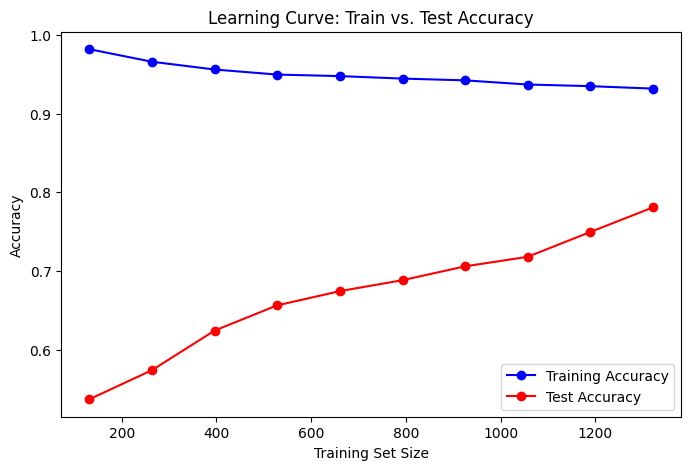

In [49]:

# 🚀 Compute Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    best_xgb_model, X_train, y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10)
)

# 🚀 Compute Mean & Standard Deviation
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# 🚀 Plot Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, "o-", label="Training Accuracy", color="blue")
plt.plot(train_sizes, test_mean, "o-", label="Test Accuracy", color="red")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve: Train vs. Test Accuracy")
plt.legend()
plt.show()

**What the learning curve is showing**
1. Training Accuracy is high (>90%) for all training data set sizes --> suggests that model is **memorizing the data / overfitting** as it should start low and get better with data
2. **Test Accuracy improves with more data** increasing from <60% to >80% with larger training data sets.
3. At lower training set sizes, it means that eg only 10% data used to train model -- but gets 90% training accuracy (**overfitting/memorizing**), and the other 90% is used for predictions -- which gets a low accuracy of 60% (**make sense as model has only learned 10% of data).
4. If training accuracy is always near 100%, but test accuracy is much lower, **it may mean the model is overfitting and would struggle with truly unseen data.**

## **Section 8: Save the Trained Model** ## <a id="save_model"></a>

Both **joblib** and **pickle** libraries are used to save and load Python objects (like machine learning models), but they work differently.

**Using joblib (Recommended for ML models)**
- import joblib
- joblib.dump(best_xgb_model, "model.pkl")  # Save
- model = joblib.load("model.pkl")  # Load

**Using pickle**
- import pickle
- with open("model.pkl", "wb") as f:
    - pickle.dump(best_xgb_model, f)
- with open("model.pkl", "rb") as f:
    - model = pickle.load(f)

**Summary: joblib.dump() vs. pickle.dump()**
|Scenario|	Use joblib?|	Use pickle?|
|--|--|--|
|Saving ML models (XGBoost, Scikit-learn)?|	✅ Yes|	❌ No|
|Saving general Python objects?	|❌ No|	✅ Yes|
|Storing large NumPy arrays?|	✅ Yes|	❌ No|
|Need speed & efficiency?	|✅ Yes|	❌ No|




In [50]:
# pickle library saves the trained model 
# it serializes the model object into a binary format and writes it into a pkl file
# later, we'll read and load the file for use in an app

with open("xgboost_model.pkl", "wb") as model_file:
    pickle.dump(best_xgb_model, model_file)


In [51]:
# we also need to save how the model is scaling input data so we can apply the same method in the application
#If your app (eg Flask API) does not scale the input data the same way as during training, predictions will be off.

# Check how your model was trained (re-do from Section 5c)
scaler = StandardScaler()
X_scaled_filtered = scaler.fit_transform(X_filtered)

# Save the scaler for API use
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

## **Section 9: Create Team Feature Lookup** <a id="team_lookup"></a> ##

**As a more user friendly option...**
- **instead of:** users filling 10+ attributes about a team and its players for both home and away teams (which they won't know)
- **do this:** users enter two teams, and the system looks up their attributes

**Solution:** We will prepare a dataset that has features the model expects for each team, and export it to a file that the apps can look up.

In [55]:
## export team features data frame to CSV file
df_team_features.to_csv("team_stats.csv", index=False)

In [56]:
checkDataset(df_team_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   teamAbbrev             32 non-null     object 
 1   avg_team_weight        32 non-null     float64
 2   avg_team_height        32 non-null     float64
 3   avg_team_age           32 non-null     float64
 4   num_CAN_players        32 non-null     int64  
 5   num_FIN_players        32 non-null     int64  
 6   OTHER                  32 non-null     int64  
 7   num_RUS_players        32 non-null     int64  
 8   num_SWE_players        32 non-null     int64  
 9   num_USA_players        32 non-null     int64  
 10  num_LeftShot_players   32 non-null     int64  
 11  num_RightShot_players  32 non-null     int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 3.1+ KB


## **Section n** <a id=<tbd>></a> ##

Train an AI Model to Predict Game Winners 🏆🔮
Now that we have structured NHL game data, we can train a machine learning model to predict which team will win based on team and player attributes.

Overview: How We’ll Build the Model

1️⃣ Define the Problem – Predict whether the home team or away team will win.
2️⃣ Select Features – Choose player & team stats as inputs.
3️⃣ Prepare the Dataset – Convert categorical data, handle missing values.
4️⃣ Train Machine Learning Models – Use Logistic Regression, Random Forest, or XGBoost.
5️⃣ Evaluate Model Performance – Check accuracy, precision, recall.
6️⃣ Make Predictions on Future Games – Predict upcoming match results.